In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-50dimension-pretrain/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt


In [2]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split



import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score,
    confusion_matrix
)

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-50dimension-pretrain/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt


2025-11-17 22:55:44.673689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763420144.871035      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763420144.926609      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Section 1: Brief description of the problem and data

We are given 7613 tweets and we need to classify them into true-disaster related, or not disaster related. 

In the training dataset, we have 7613 rows, each of them contains natural language of a tweet in "text" column, and a boolean value in "target" column indicating if it is a real disaster or not.

In [3]:
raw_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
raw_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# Section 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Let's take a look at what info will the "keyword" column provide

In [5]:
raw_df[raw_df["keyword"].notna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [6]:
raw_df[raw_df["keyword"].isna()]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


I can see 61 rows without keyword

In [7]:
labels_count = raw_df.target.value_counts()
labels_count

target
0    4342
1    3271
Name: count, dtype: int64

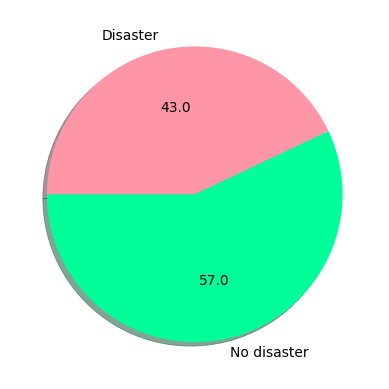

<Figure size 1600x1600 with 0 Axes>

In [8]:
%matplotlib inline
plt.pie(labels_count, labels=['No disaster', 'Disaster'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

## Observation

- We can see we have 57% tweets are no disaster (target=0). 43% are disaster.
- I also notice the column "keyword" doesn't provide useful info. The same keyword like `ablaze` may or may not indicate a real disaster.

## Data cleaning

- I want to make all of the words in lower case, and remove special formatting like '\n'
- The text may contain many low-value words like "a", "the". Also some phrases like "@jt_ruff23" doesn't provide meaning for the prediction. Should remove them.

In [9]:
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
raw_df['message_clean'] = raw_df['text'].apply(clean_text)
raw_df.head()

,id,keyword,location,text,target,message_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [11]:
# use stopwords to remove "a", "the" and so on
stop_words = stopwords.words('english')
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [12]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
raw_df['message_clean'] = raw_df['message_clean'].apply(remove_stopwords)
raw_df.head()

,id,keyword,location,text,target,message_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders ca...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


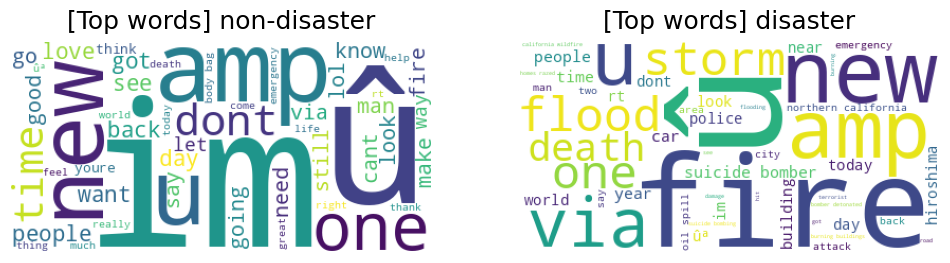

In [13]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def show_word_cloud(raw_df):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))
    
    # target = 0, non disaster
    wc = WordCloud(
        background_color='white', 
        max_words=50
    )
    wc.generate(' '.join(text for text in raw_df.loc[raw_df['target'] == 0, 'message_clean']))
    ax[0].set_title('[Top words] non-disaster', 
              fontdict={'size': 18,  'verticalalignment': 'bottom'})
    ax[0].imshow(wc)
    ax[0].axis("off")
    
    
    # target = 1, disaster
    wc = WordCloud(
        background_color='white', 
        max_words=50
    )
    wc.generate(' '.join(text for text in raw_df.loc[raw_df['target'] == 1, 'message_clean']))
    ax[1].set_title('[Top words] disaster', 
              fontdict={'size': 18,  'verticalalignment': 'bottom'})
    ax[1].imshow(wc)
    ax[1].axis("off")

show_word_cloud(raw_df)

In [14]:
raw_string = ' '.join(text for text in raw_df['message_clean'])
raw_string[:2000]

'deeds reason earthquake may allah forgive us forest fire near la ronge sask canada residents asked shelter place notified officers evacuation shelter place orders expected  people receive wildfires evacuation orders california  got sent photo ruby alaska smoke wildfires pours school  rockyfire update  california hwy  closed directions due lake county fire  cafire wildfires flood disaster heavy rain causes flash flooding streets manitou colorado springs areas im top hill see fire woods theres emergency evacuation happening building across street im afraid tornado coming area three people died heat wave far haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding raining flooding florida tampabay tampa   days ive lost count  flood bago myanmar arrived bago damage school bus  multi car crash breaking  whats man love fruits summer lovely car fast goooooooaaaaaal ridiculous london cool  love skiing wonderful day looooool wayi cant eat shit nyc last week l

In [15]:
from collections import Counter
raw_string = ' '.join(text for text in raw_df['message_clean'])
word_cnt = Counter(raw_string.split(' '))
word_cnt.most_common(20)

[('', 10668),
 ('like', 344),
 ('amp', 298),
 ('im', 294),
 ('fire', 248),
 ('get', 228),
 ('new', 223),
 ('via', 220),
 ('people', 196),
 ('one', 191),
 ('dont', 189),
 ('news', 185),
 ('us', 162),
 ('video', 158),
 ('emergency', 156),
 ('disaster', 150),
 ('police', 137),
 ('would', 129),
 ('still', 128),
 ('body', 124)]

Seems that some meaningless words like "u", "im" appears a lot. Need further cleanup.

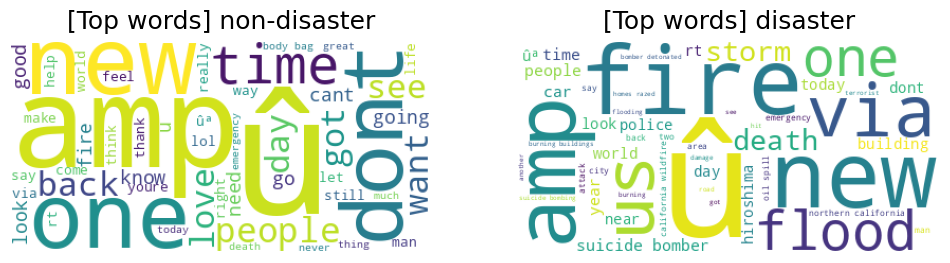

In [16]:
my_customized_stopword = ["u", "im", "û"]

def remove_stopwords_v2(text):
    text = ' '.join(word for word in text.split(' ') if word not in my_customized_stopword)
    return text
    
raw_df['message_clean'] = raw_df['message_clean'].apply(remove_stopwords_v2)
show_word_cloud(raw_df)

# Section 3: Model architecture

- Sequential model: As discussed in week4 class, I plan to use RNN to train and predict the binary predictions here. The reason is that, RNN is good for document processing, especially for sentiment analysis.
- Process text into matrix: Before RNN, I need to tokenize the tweet text into tokens/embedding.
  - Tokenization is to convert word to number. The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.
  - Word embeddings are essentially the features from the words. 1 word will be mapped to a vector containing different features, like "the" -> [0.5, -0.5, 0.8].

In [17]:
texts = raw_df['message_clean']
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

16699

## Tokenization

#### The tokenizer below, can assign an index to each of the words ever appears in our text (or to say, "vocabulary")

In [18]:
# visualize how the tokenizer looks like
for idx, word in enumerate(word_tokenizer.word_index):
    if idx > 20:
        break
    word_idx = word_tokenizer.word_index[word]
    print(f"{word}: {word_idx}")
    

like: 1
amp: 2
fire: 3
get: 4
new: 5
via: 6
people: 7
one: 8
dont: 9
news: 10
us: 11
video: 12
emergency: 13
disaster: 14
police: 15
would: 16
still: 17
body: 18
burning: 19
back: 20
california: 21


Now I need to pad the text to make sure they are the `same length`, so that they can be processed the same.

In [19]:
# test to see how padding works
pad_sequences([[1], [2, 3], [4, 5, 6]], padding='post')

array([[1, 0, 0],
       [2, 3, 0],
       [4, 5, 6]], dtype=int32)

In [20]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts), 
    length_long_sentence, 
    padding='post'
)

train_padded_sentences

array([[4163,  721,  140, ...,    0,    0,    0],
       [  92,    3,  122, ...,    0,    0,    0],
       [1511, 1389, 1879, ...,    0,    0,    0],
       ...,
       [ 457, 1378,    0, ...,    0,    0,    0],
       [  15,  950, 2892, ...,    0,    0,    0],
       [ 109,  104,  408, ...,    0,    0,    0]], dtype=int32)

In [21]:
# let me try to compare the tokenized array vs. the original text sentence, 
# to make sure everything is correct

print(f"length_long_sentence={length_long_sentence}")
print(texts[0])
print(train_padded_sentences[0])
mywords = []
for word in texts[0].split(' '):
    mywords.append((word_tokenizer.word_index[word], word))
mywords

length_long_sentence=23
deeds reason earthquake may allah forgive us
[4163  721  140   52 1510 4164   11    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


[(4163, 'deeds'),
 (721, 'reason'),
 (140, 'earthquake'),
 (52, 'may'),
 (1510, 'allah'),
 (4164, 'forgive'),
 (11, 'us')]

### GloVe

GloVe method is built on an important idea,

> You can derive semantic relationships between words from the co-occurrence matrix.

To obtain a vector representation for words we can use an unsupervised learning algorithm called **GloVe (Global Vectors for Word Representation)**, which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.

Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network.

## I need to download the GloVe file from stanford first, to be able to use their pre-trained info on word embedding.
- /kaggle/input/glove-50dimension-pretrain/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt is the pre-trained weight I downloaded and uploaded to kaggle.
- This weight contains 50D, and has size of 800Mb, which is the smallest and good for this weekly assignment.

In [22]:
embeddings_dictionary = dict()
embedding_dim = 50

# Load GloVe wiki gaga 2024 50D embeddings
glove_path = "/kaggle/input/glove-50dimension-pretrain/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt"
with open(glove_path) as fp:
    for line in fp.readlines():
        try:
            records = line.split()
            word = records[0]
            vector_dimensions = np.asarray(records[1:], dtype='float32')
            embeddings_dictionary [word] = vector_dimensions
        except:
            print(records)
            print("continue")

# embeddings_dictionary

['.', '.', '.', '0.076316', '0.582398', '-0.347526', '-0.031021000000000003', '0.12879799999999997', '-0.585158', '0.15246900000000002', '0.206034', '0.151978', '-0.254758', '-0.8013669999999999', '-0.27485099999999996', '-0.180747', '-0.08329900000000001', '0.092969', '-0.21377000000000002', '-0.028837999999999975', '-1.162776', '0.567045', '0.497675', '-0.41591100000000003', '0.040301000000000003', '0.784606', '0.9728990000000001', '-0.07302600000000001', '0.12436', '-0.6826840000000001', '0.434515', '0.333855', '-0.38612199999999997', '-0.110762', '0.11772500000000001', '-0.255006', '-0.530582', '-0.32309299999999996', '-0.264652', '-0.09885100000000001', '2.837948', '0.065199', '0.081899', '0.125319', '0.328958', '-0.214473', '0.9800719999999999', '-0.931648', '-0.27523600000000004', '0.18426599999999999', '0.221145', '0.146854', '0.437076']
continue
['2', '1/2', '0.8830849999999999', '-0.443334', '-0.431213', '-0.8032079999999999', '-0.6550009999999999', '-0.189898', '-1.245215', 

In [23]:
# we have a pre-trained vocabulary of size 1.2M
len(embeddings_dictionary)

1287623

In [24]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)
embedding_matrix

(16699, 50)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.56117302, -0.197797  ,  0.021335  , ..., -0.091443  ,
         0.11703   ,  0.71193701],
       [-0.33927101,  0.34474999,  0.44257399, ..., -0.94811499,
         0.26032799, -0.190384  ],
       ...,
       [ 0.309044  ,  0.024495  ,  0.01146   , ..., -0.190752  ,
        -0.69017899, -0.196373  ],
       [ 0.42998901, -0.018572  ,  0.87680697, ..., -0.062777  ,
        -0.008264  , -0.171932  ],
       [ 1.07359803, -0.002487  , -1.27603805, ..., -0.41540599,
        -0.150162  , -0.079669  ]])

## build and train RNN

In [25]:
# Split data into train and test sets
target = raw_df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    target, 
    test_size=0.25
)

after the split, we got 5709 training samples, and 1904 validation samples

In [26]:
y_test

7192    1
7611    1
7444    0
2699    0
5104    1
       ..
4728    0
7153    0
622     1
3173    1
6453    0
Name: target, Length: 1904, dtype: int64

In [27]:
X_train.shape

(5709, 23)

In [28]:
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = glove_lstm()
model.summary()

2025-11-17 22:59:12.114106: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       834,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,950 (3.19 MB)

 Trainable params: 834,950 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

# Section 4: Results and Analysis

Let's run the baseline model first 

In [33]:
# Load the model and train!!

model = glove_lstm()

history = model.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5381 - loss: 0.8135 - val_accuracy: 0.7526 - val_loss: 0.6517
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6430 - loss: 0.6406 - val_accuracy: 0.7999 - val_loss: 0.5518
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7209 - loss: 0.5655 - val_accuracy: 0.8015 - val_loss: 0.4746
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7553 - loss: 0.5284 - val_accuracy: 0.8020 - val_loss: 0.4480
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7747 - loss: 0.5157 - val_accuracy: 0.8057 - val_loss: 0.4473
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7992 - loss: 0.4715 - val_accuracy: 0.8088 - val_loss: 0.4380
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8013 - loss: 0.4654 - val_accuracy: 0.8114 - val_loss: 0.4491
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8213 - loss: 0.4263 - val_acc

In [34]:
history.history

{'accuracy': [0.5610439777374268,
  0.6603608131408691,
  0.7334033846855164,
  0.7623051404953003,
  0.7808722853660583,
  0.7983884811401367,
  0.8074969053268433,
  0.8227360248565674,
  0.8250131607055664,
  0.834296703338623],
 'loss': [0.7593986392021179,
  0.6247613430023193,
  0.5469578504562378,
  0.524151086807251,
  0.5025370717048645,
  0.4780121147632599,
  0.45496150851249695,
  0.4331662356853485,
  0.43228551745414734,
  0.4188200533390045],
 'val_accuracy': [0.7526260614395142,
  0.7998949289321899,
  0.8014705777168274,
  0.8019958138465881,
  0.805672287940979,
  0.8088235259056091,
  0.8114495873451233,
  0.8161764740943909,
  0.8151260614395142,
  0.8125],
 'val_loss': [0.6517113447189331,
  0.5517898201942444,
  0.47459080815315247,
  0.44795161485671997,
  0.4472807049751282,
  0.43800538778305054,
  0.4490935206413269,
  0.43485593795776367,
  0.43243488669395447,
  0.44420456886291504]}

In [35]:
def plot_learning_curves(history):
    arr = [['loss', 'val_loss'],['accuracy', 'val_accuracy']]
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('epoch ',fontsize=16)
        ax[idx].set_ylabel(arr[idx][0] ,fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' vs. ' + arr[idx][1],fontsize=16)


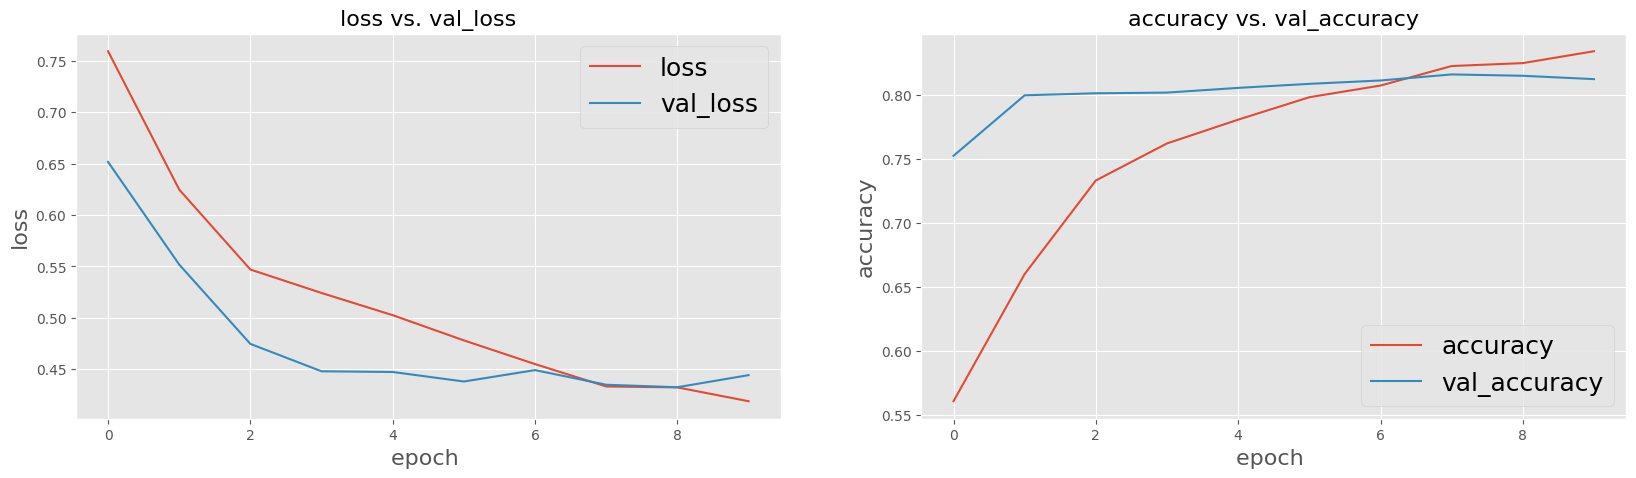

In [36]:
plot_learning_curves(history)

## Observation

As we can see, when epoch goes, the training loss continuously goes down and training accuracy continuously goes up. However, on validation dataset, the loss and accuracy becomes flat after at around epoch 4.

In [30]:
y_preds = (model.predict(X_test) > 0.5).astype("int32")


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [47]:
print(f"accuracy_score={accuracy_score(y_test, y_preds)}")
print(f"precision_score={precision_score(y_test, y_preds)}")
print(f"recall_score={recall_score(y_test, y_preds)}")
print(f"f1_score={f1_score(y_test, y_preds)}")

accuracy_score=0.8125
precision_score=0.8309859154929577
recall_score=0.6807692307692308
f1_score=0.748414376321353


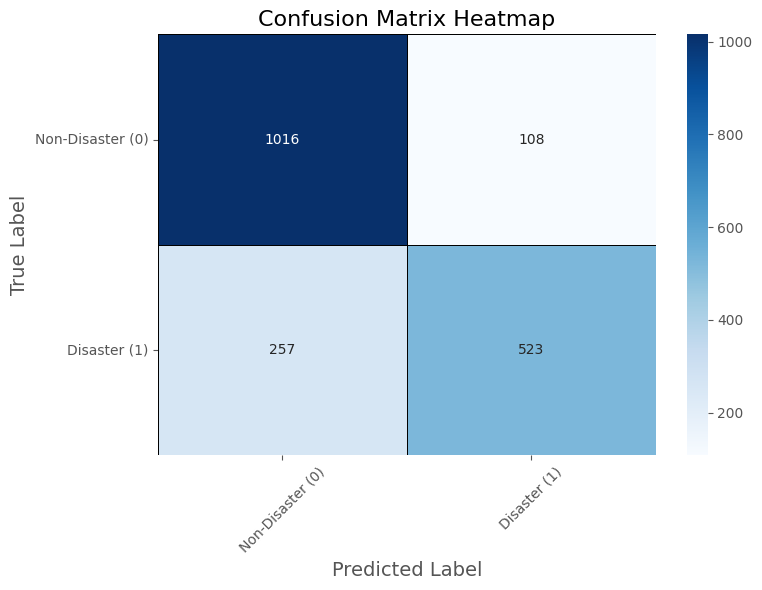

In [32]:
# confusion matrix

conf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(8, 6))

# Use seaborn.heatmap()
sns.heatmap(
    conf_matrix,
    annot=True,          # Display the numerical values in the cells
    fmt='d',             # Use integer format ('d' for decimal) for the numbers
    cmap='Blues',        # Choose a suitable color map (e.g., 'Blues', 'YlGnBu')
    cbar=True,           # Display the color bar
    linewidths=0.5,      # Add lines between cells for better separation
    linecolor='black'    # Color of the lines
)

# 3. Add Labels and Titles for clarity
class_names = ['Non-Disaster (0)', 'Disaster (1)']
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45)
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
plt.title('Confusion Matrix Heatmap', fontsize=16)

# Ensure the plot is laid out nicely
plt.tight_layout()

# Display the plot (in a Jupyter environment, this may not be needed explicitly)
plt.show()

## Hyperparameter tuning

I notice the inter-layer drop out rate is 0.5, which may be too high. Let me tune the drop out rate to lower value to see.

In [37]:
def glove_lstm_low_dropout():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.25))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model_low_dropout = glove_lstm_low_dropout()
model_low_dropout.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │       834,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,950 (3.19 MB)

 Trainable params: 834,950 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.6027 - loss: 0.6791 - val_accuracy: 0.8041 - val_loss: 0.5614
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7663 - loss: 0.5050 - val_accuracy: 0.8057 - val_loss: 0.4641
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7935 - loss: 0.4704 - val_accuracy: 0.8172 - val_loss: 0.4285
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8135 - loss: 0.4287 - val_accuracy: 0.8172 - val_loss: 0.4347
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8250 - loss: 0.4196 - val_accuracy: 0.8199 - val_loss: 0.4239
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8285 - loss: 0.3948 - val_accuracy: 0.8141 - val_loss: 0.4332
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8421 - loss: 0.3806 - val_accuracy: 0.8183 - val_loss: 0.4237
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8563 - loss: 0.3416 - val_acc

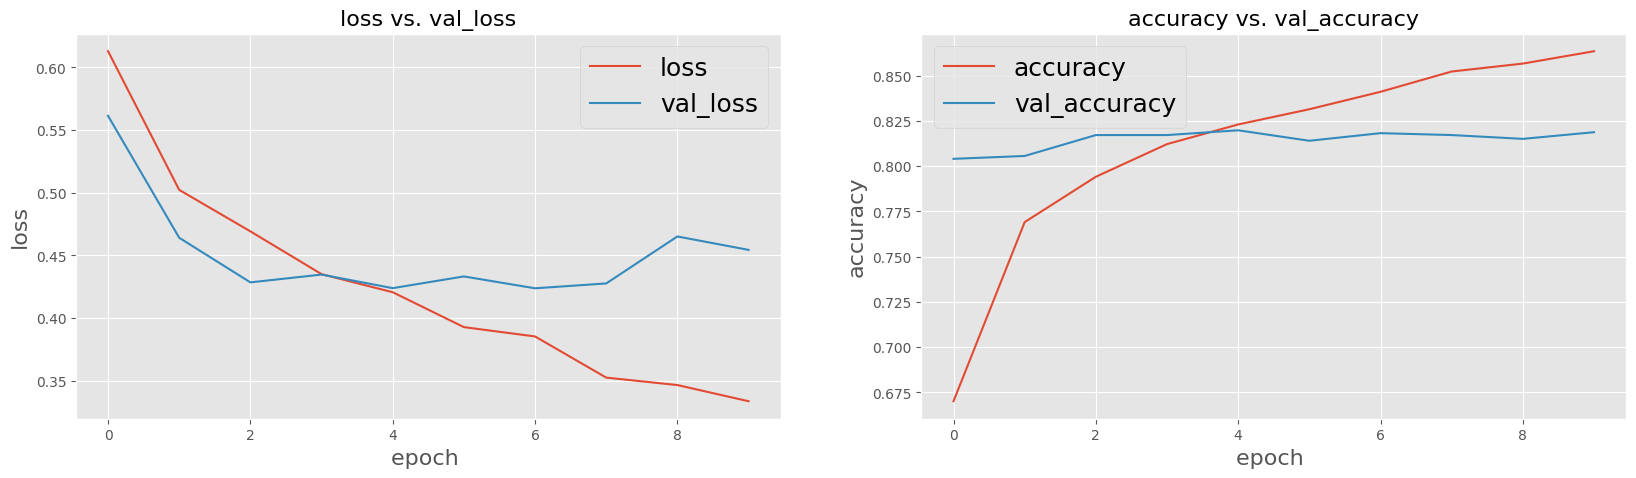

In [38]:
history_low_dropout = model_low_dropout.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1
)
plot_learning_curves(history_low_dropout)

## Comparing the base model and low_dropout model

In [48]:
y_preds_low_dropout = (model_low_dropout.predict(X_test) > 0.5).astype("int32")

print(f"accuracy_score={accuracy_score(y_test, y_preds_low_dropout)}")
print(f"precision_score={precision_score(y_test, y_preds_low_dropout)}")
print(f"recall_score={recall_score(y_test, y_preds_low_dropout)}")
print(f"f1_score={f1_score(y_test, y_preds_low_dropout)}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
accuracy_score=0.8188025210084033
precision_score=0.8290468986384266
recall_score=0.7025641025641025
f1_score=0.7605829285218598


We can see when the dropout rate decreases from 0.5 to 0.25, the overall model performance compared with the base model sees some improvement:
- accuracy: 80.8% -> 81.9%
- F1 score: 74.8% -> 76.1%

Also, there is a more clear sign of overfitting when the dropout rate reduced (lower dropout rate means larger model):
- training loss keeps decreasing, however, the validation loss starts to increase since epoch 7.

Therefore, let me early stop with epoch 7.

Epoch 1/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.6007 - loss: 0.6775 - val_accuracy: 0.7195 - val_loss: 0.5982
Epoch 2/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7603 - loss: 0.5075 - val_accuracy: 0.7894 - val_loss: 0.4784
Epoch 3/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8019 - loss: 0.4569 - val_accuracy: 0.8020 - val_loss: 0.4426
Epoch 4/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8071 - loss: 0.4408 - val_accuracy: 0.8078 - val_loss: 0.4455
Epoch 5/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8167 - loss: 0.4284 - val_accuracy: 0.8214 - val_loss: 0.4226
Epoch 6/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8372 - loss: 0.3989 - val_accuracy: 0.8193 - val_loss: 0.4326
Epoch 7/7
179/179 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8425 - loss: 0.3796 - val_accuracy: 0.8114 - val_loss: 0.4436


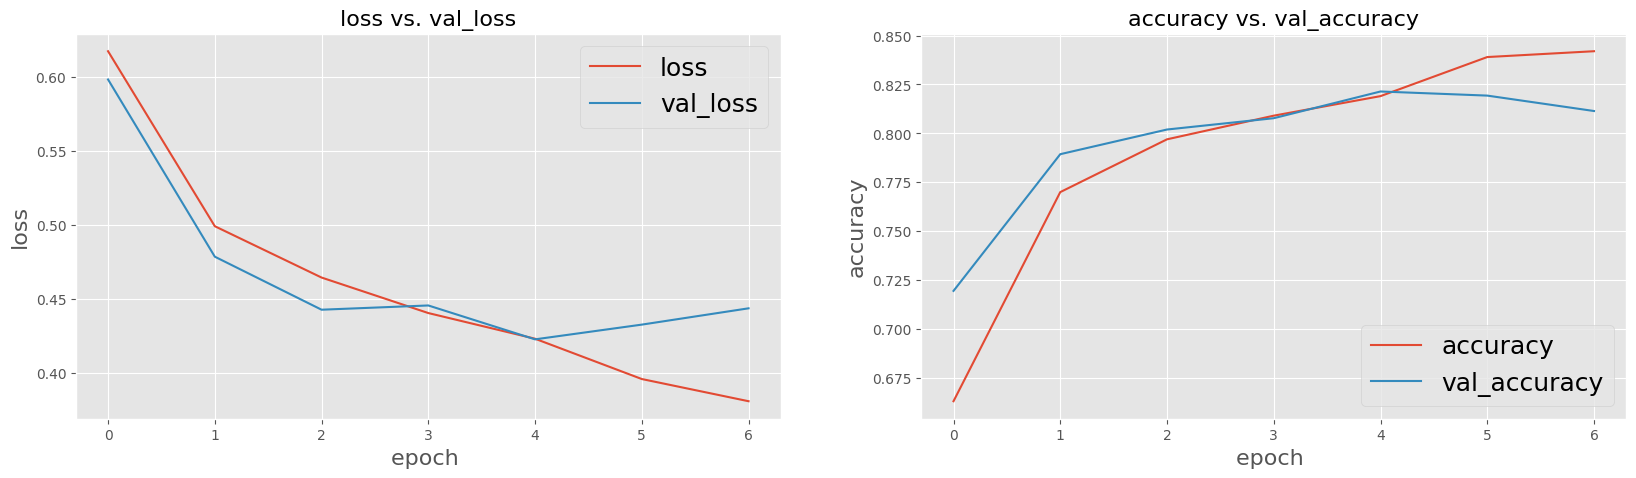

In [43]:
model_low_dropout_early_stop = glove_lstm_low_dropout()

history_low_dropout_early_stop = model_low_dropout_early_stop.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1
)
plot_learning_curves(history_low_dropout_early_stop)

In [45]:
y_preds_low_dropout_early_stop = (model_low_dropout_early_stop.predict(X_test) > 0.5).astype("int32")

print(f"accuracy_score={accuracy_score(y_test, y_preds_low_dropout_early_stop)}")
print(f"precision_score={precision_score(y_test, y_preds_low_dropout_early_stop)}")
print(f"recall_score={recall_score(y_test, y_preds_low_dropout_early_stop)}")
print(f"f1_score={f1_score(y_test, y_preds_low_dropout_early_stop)}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
accuracy_score=0.8114495798319328
precision_score=0.7825503355704698
recall_score=0.7474358974358974
f1_score=0.7645901639344262


The result is mixed:
- accuracy: 80.8% (base) -> 81.9% (low dropout) -> 81.8% (low dropout, early stop)
- F1 score: 74.8% (base) -> 76.1% (low dropout) -> 76.5% (low dropout, early stop)

## Different model architecture

In the base model, I used Bidirectional LSTM, which may be an overkill. I want to try a simpler model to see any performance difference.

In [40]:
def glove_lstm_oneway():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    ))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model_oneway = glove_lstm_oneway()
model_oneway.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │       834,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_4          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 834,950 (3.19 MB)

 Trainable params: 834,950 (3.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5519 - loss: 0.8667 - val_accuracy: 0.7610 - val_loss: 0.6645
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6168 - loss: 0.6683 - val_accuracy: 0.7862 - val_loss: 0.5578
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7178 - loss: 0.5655 - val_accuracy: 0.7978 - val_loss: 0.4694
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7603 - loss: 0.5190 - val_accuracy: 0.8015 - val_loss: 0.4491
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7930 - loss: 0.5143 - val_accuracy: 0.8057 - val_loss: 0.4415
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7936 - loss: 0.4885 - val_accuracy: 0.8136 - val_loss: 0.4268
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8082 - loss: 0.4473 - val_accuracy: 0.8114 - val_loss: 0.4295
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8236 - loss: 0.4448 - val_accu

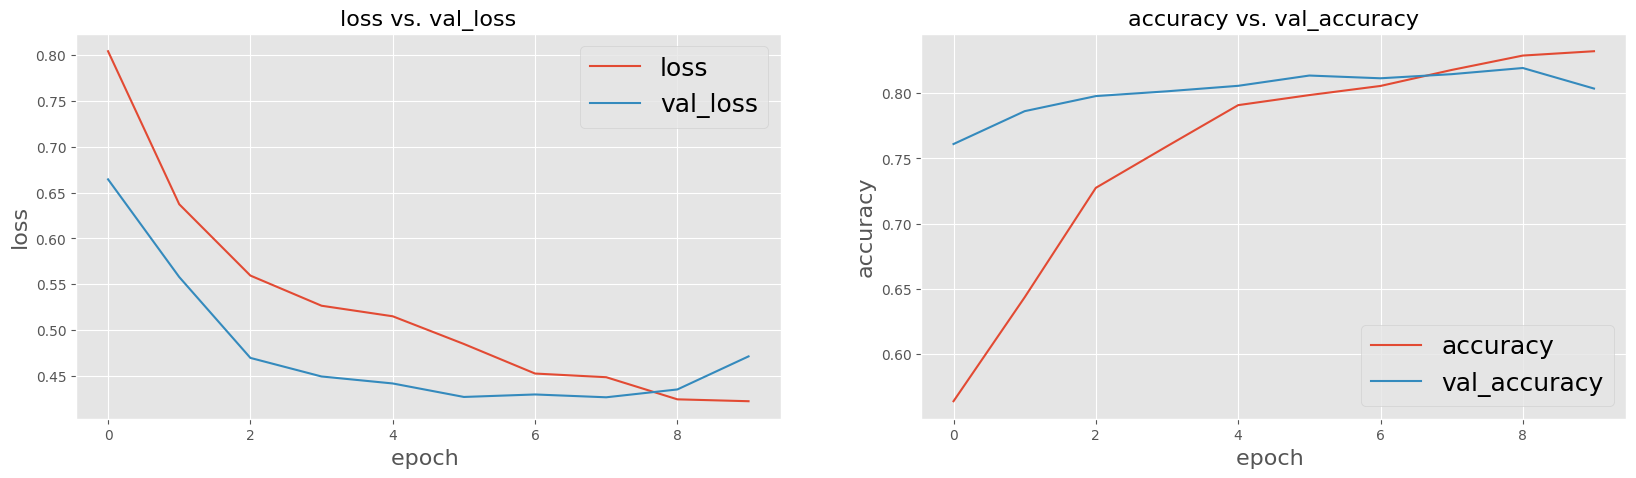

In [41]:
history_oneway = model_oneway.fit(
    X_train, 
    y_train, 
    epochs = 10,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1
)
plot_learning_curves(history_oneway)

In [44]:
y_preds_oneway = (model_oneway.predict(X_test) > 0.5).astype("int32")

print(f"accuracy_score={accuracy_score(y_test, y_preds_oneway)}")
print(f"precision_score={precision_score(y_test, y_preds_oneway)}")
print(f"recall_score={recall_score(y_test, y_preds_oneway)}")
print(f"f1_score={f1_score(y_test, y_preds_oneway)}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
accuracy_score=0.8035714285714286
precision_score=0.7576142131979695
recall_score=0.7653846153846153
f1_score=0.7614795918367346



We can see when bidirection changes to oneway, the overall model performance compared with the base model is mixed: lower accuracy, higher F1
- accuracy: 80.8% -> 80.4%
- F1 score: 74.8% -> 76.1%

# Section 5: Conclusion

In the experiments above, I tuned hyperparameters including dropout rate and training epoch, and tried different model architectures (oneway vs. bidirectional).

The overall takeaway is that, typically model with more capacity and complexity (for example, low dropout rate), may have better performance in terms of F1 score. Here are my thoughts:
- We may see accuracy drop comes together with F1 score increase, providing conflicting info. But F1 should be more important, given that accuracy metrics may perform bad in biased dataset (for example, lots of 0 and very few 1).



In future, I may want to try a different architecture. Currently I have 3 dense layer and 3 dropout layers. I may want to try a deeper model like 4 layers to see any performance difference.

# Reference

- https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
- https://www.kaggle.com/code/vadbeg/pytorch-lstm-with-disaster-tweets
- https://medium.com/@harshrao22comp/understanding-glove-a-global-vectors-approach-to-word-embeddings-e37ce6e36f94
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
- Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]
- Riley Carlson, John Bauer, and Christopher D. Manning. 2025. A New Pair of GloVes. [pdf]